# Prediction of the Prices of Toyota Corolla

**Business case:** the CEO from Toyota Barcelona has contacted us because she is interested in having a model to predict the prices of the different Corolla models that he is selling. 

    Right now, they have developed and algorithm that has an error of 50%, so they are not feeling really confident with their results. She has contacted us because she is interested in having a model with better Accuracy. Can you help her?

# Overview

Columns:
- <b> Age: </b> Age in years
- <b> KM: </b> Accumulated Kilometers on odometer
- <b> FuelType: </b> Fuel Type (Petrol, Diesel, CNG)
- <b> HP: </b> Horse Power
- <b> MetColor: </b> Metallic Color? (Yes=1, No=0)
- <b> Automatic: </b> Automatic ( (Yes=1, No=0)
- <b> CC: </b> Cylinder Volume in cubic centimeters
- <b> Doors: </b> Number of doors
- <b> Weight: </b> Weight in Kilograms
- <b> Price: </b> Offer Price in EUROs

# Importing Libraries and Reading the Dataset

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from collections import Counter
from IPython.core.display import display, HTML
from sklearn.preprocessing import LabelEncoder
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder
from sklearn import metrics
from sklearn.metrics import r2_score

from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV
from sklearn.svm import SVR
sns.set_style('darkgrid')

In [4]:
dataset = pd.read_csv('../../datasets/Students_turn/Ex3.2.ToyotaCorolla.csv')
dataset.head()

,Price,Age,KM,FuelType,HP,MetColor,Automatic,CC,Doors,Weight
0,13500,23,46986,Diesel,90,1,0,2000,3,1165
1,13750,23,72937,Diesel,90,1,0,2000,3,1165
2,13950,24,41711,Diesel,90,1,0,2000,3,1165
3,14950,26,48000,Diesel,90,0,0,2000,3,1165
4,13750,30,38500,Diesel,90,0,0,2000,3,1170


# EDA

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Price      1436 non-null   int64 
 1   Age        1436 non-null   int64 
 2   KM         1436 non-null   int64 
 3   FuelType   1436 non-null   object
 4   HP         1436 non-null   int64 
 5   MetColor   1436 non-null   int64 
 6   Automatic  1436 non-null   int64 
 7   CC         1436 non-null   int64 
 8   Doors      1436 non-null   int64 
 9   Weight     1436 non-null   int64 
dtypes: int64(9), object(1)
memory usage: 112.3+ KB


In [6]:
dataset.columns

Index(['Price', 'Age', 'KM', 'FuelType', 'HP', 'MetColor', 'Automatic', 'CC',
       'Doors', 'Weight'],
      dtype='object')

In [7]:
# It seems there are no Null Values.
dataset.isnull().sum()

Price        0
Age          0
KM           0
FuelType     0
HP           0
MetColor     0
Automatic    0
CC           0
Doors        0
Weight       0
dtype: int64

In [8]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,1436.0,10730.824513,3626.964585,4350.0,8450.0,9900.0,11950.00,32500.0
Age,1436.0,55.947075,18.599988,1.0,44.0,61.0,70.00,80.0
KM,1436.0,68533.259749,37506.448872,1.0,43000.0,63389.5,87020.75,243000.0
HP,1436.0,101.502089,14.981080,69.0,90.0,110.0,110.00,192.0
MetColor,1436.0,0.674791,0.468616,0.0,0.0,1.0,1.00,1.0
Automatic,1436.0,0.055710,0.229441,0.0,0.0,0.0,0.00,1.0
CC,1436.0,1566.827994,187.182436,1300.0,1400.0,1600.0,1600.00,2000.0
Doors,1436.0,4.033426,0.952677,2.0,3.0,4.0,5.00,5.0
Weight,1436.0,1072.459610,52.641120,1000.0,1040.0,1070.0,1085.00,1615.0


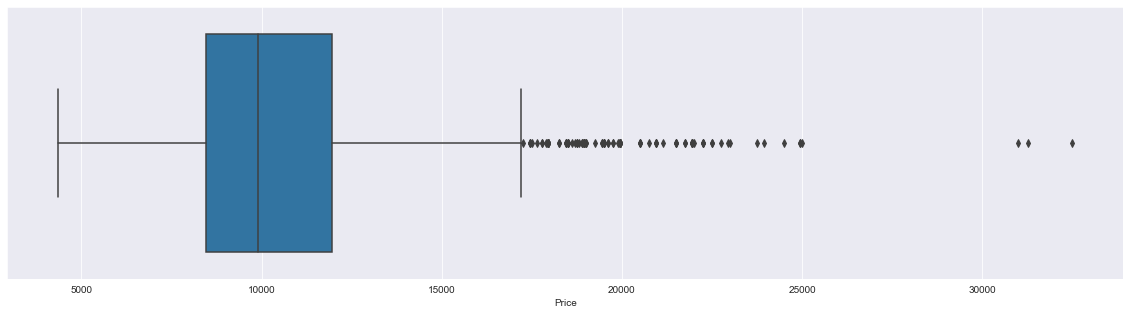

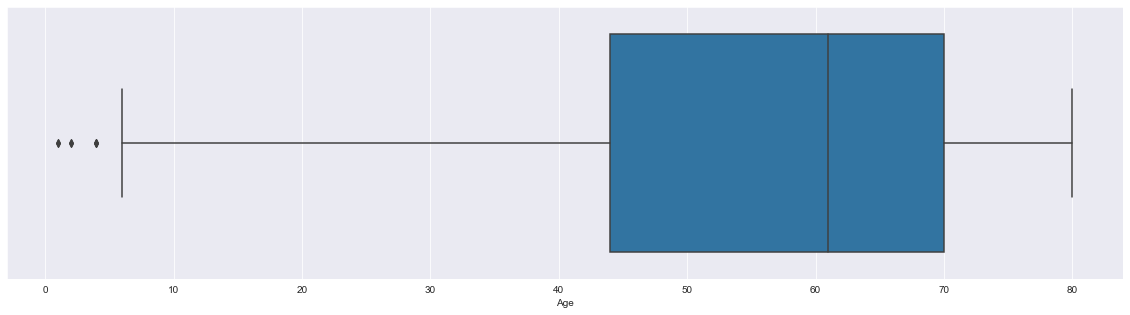

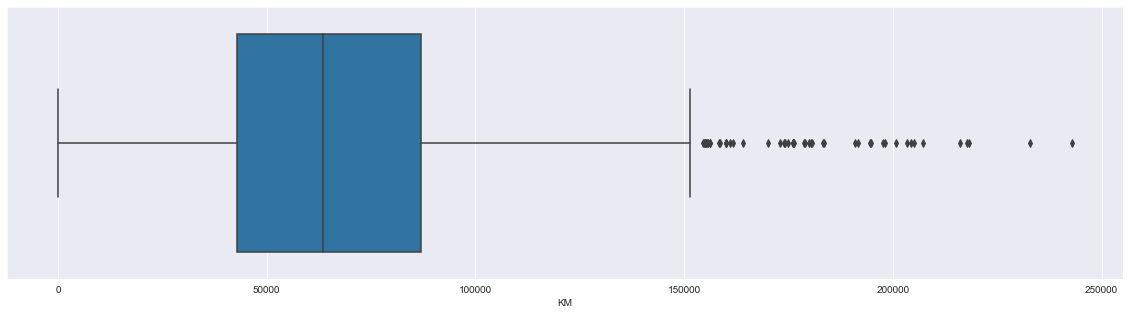

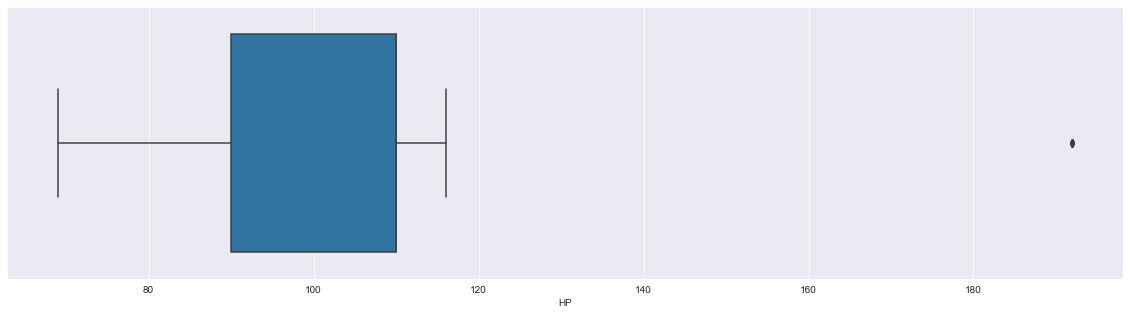

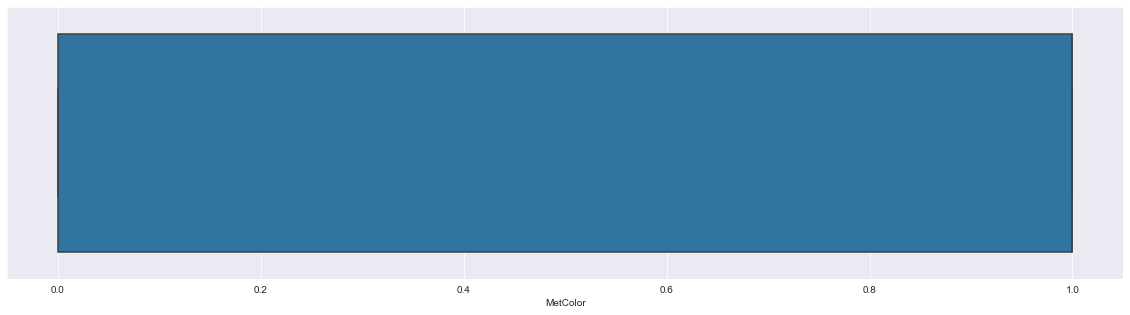

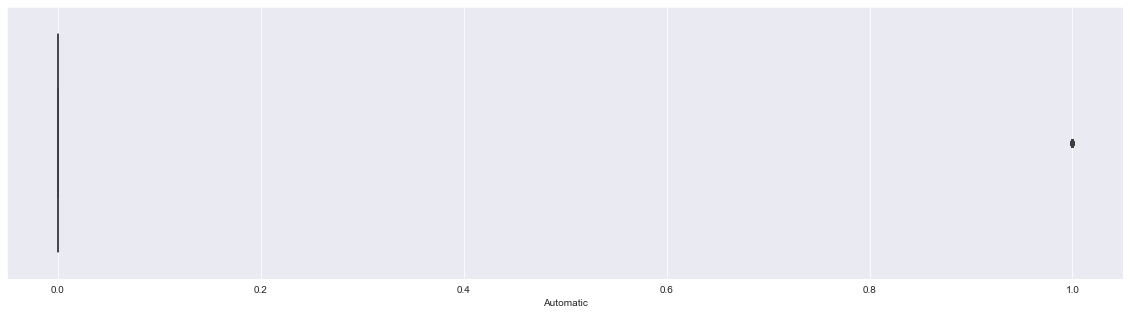

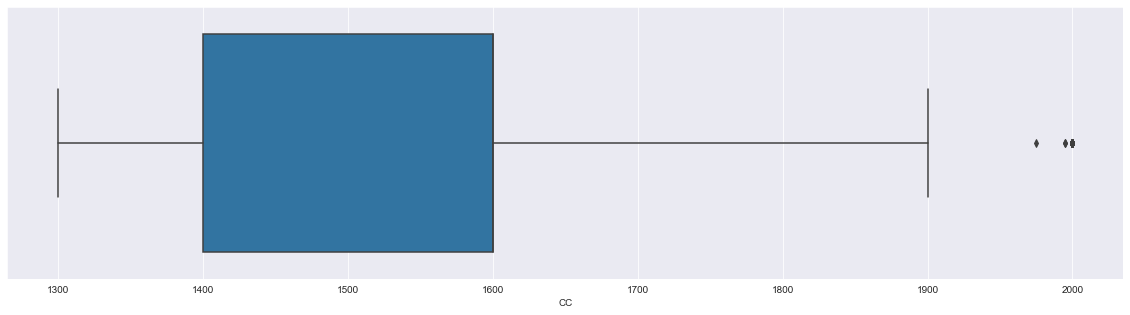

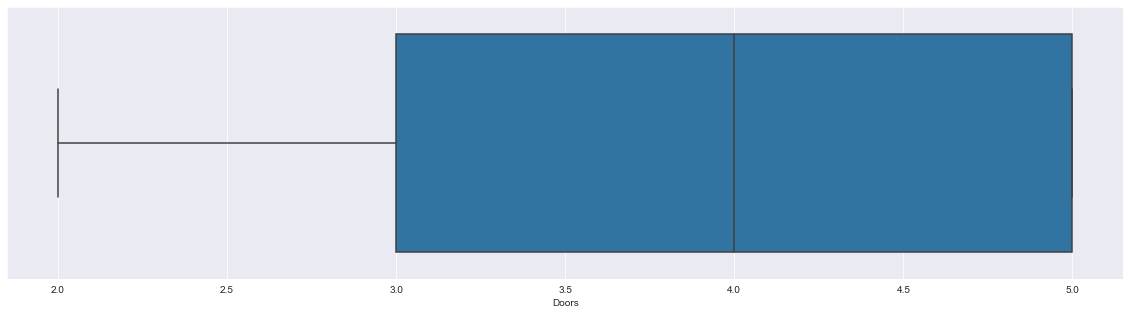

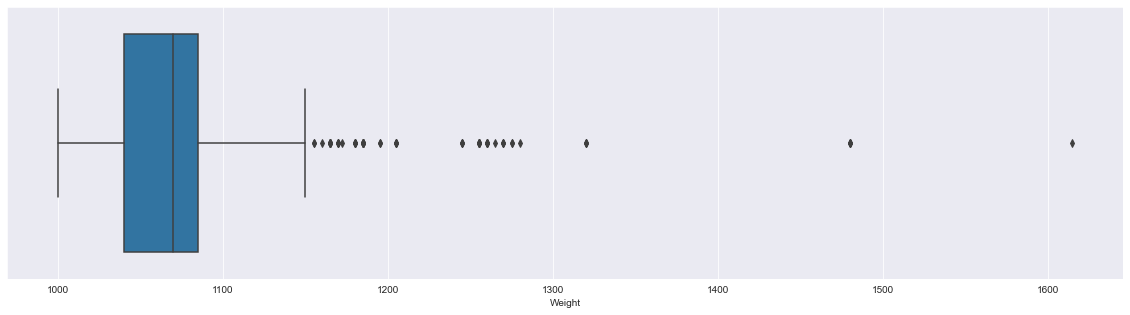

In [9]:
for col in dataset:
    if dataset[col].dtype == np.float64 or dataset[col].dtype == np.int64:
        fig_dims = (20, 5)
        fig, ax = plt.subplots(figsize=fig_dims)
        sns.boxplot(x=dataset[col],ax=ax)

In [10]:
# Notes: Age of the cars seems a bit odd because there are cars with an age of 60+ and Toyota Corolla
# was launched in 1966 !
# Also there is a very evident outlier in the HP column.

In [11]:
# Yes=1, No=0

dataset["Automatic"].value_counts()

0    1356
1      80
Name: Automatic, dtype: int64

In [12]:
# Outliers: the most evident one is in the HP feature and we will drop it

In [13]:
dataset["HP"].value_counts().sort_values()

73       1
71       1
98       2
116      9
192     11
107     21
69      34
90      36
72      73
97     164
86     249
110    835
Name: HP, dtype: int64

In [14]:
dataset = dataset[dataset["HP"]<192]
dataset_num = dataset.drop("FuelType", axis=1)

In [15]:
dataset_num.HP.max()

116

In [16]:
# Check for correlations

In [17]:
data_corr = dataset_num.corr()
data_corr

,Price,Age,KM,HP,MetColor,Automatic,CC,Doors,Weight
Price,1.000000,-0.880405,-0.571133,0.213047,0.118349,0.040218,0.141969,0.204451,0.560796
Age,-0.880405,1.000000,0.501137,-0.100082,-0.113717,0.029083,-0.120069,-0.156376,-0.456870
KM,-0.571133,0.501137,1.000000,-0.344114,-0.084129,-0.083921,0.314098,-0.041538,-0.013588
HP,0.213047,-0.100082,-0.344114,1.000000,0.084874,0.028888,-0.008601,0.137874,-0.014136
MetColor,0.118349,-0.113717,-0.084129,0.084874,1.000000,-0.019950,0.037980,0.080618,0.063768
Automatic,0.040218,0.029083,-0.083921,0.028888,-0.019950,1.000000,-0.067405,-0.028747,0.062488
CC,0.141969,-0.120069,0.314098,-0.008601,0.037980,-0.067405,1.000000,0.133075,0.646262
Doors,0.204451,-0.156376,-0.041538,0.137874,0.080618,-0.028747,0.133075,1.000000,0.318032
Weight,0.560796,-0.456870,-0.013588,-0.014136,0.063768,0.062488,0.646262,0.318032,1.000000


<AxesSubplot:>

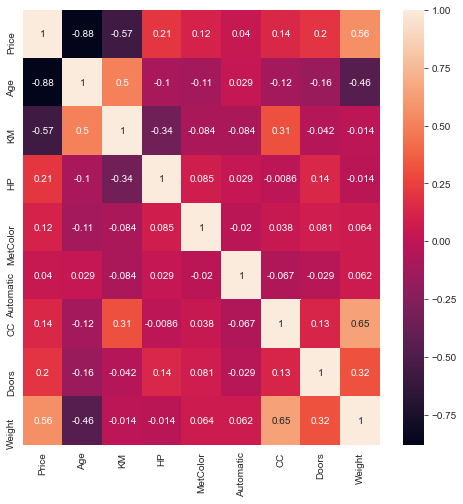

In [18]:
f, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.heatmap(data_corr,annot=True)

In [19]:
# Price and weight are positively correlated and
# Weight and CC too.
# While Age and Price are negatively correlated, which makes sense
# because the older the car the less it will cost.

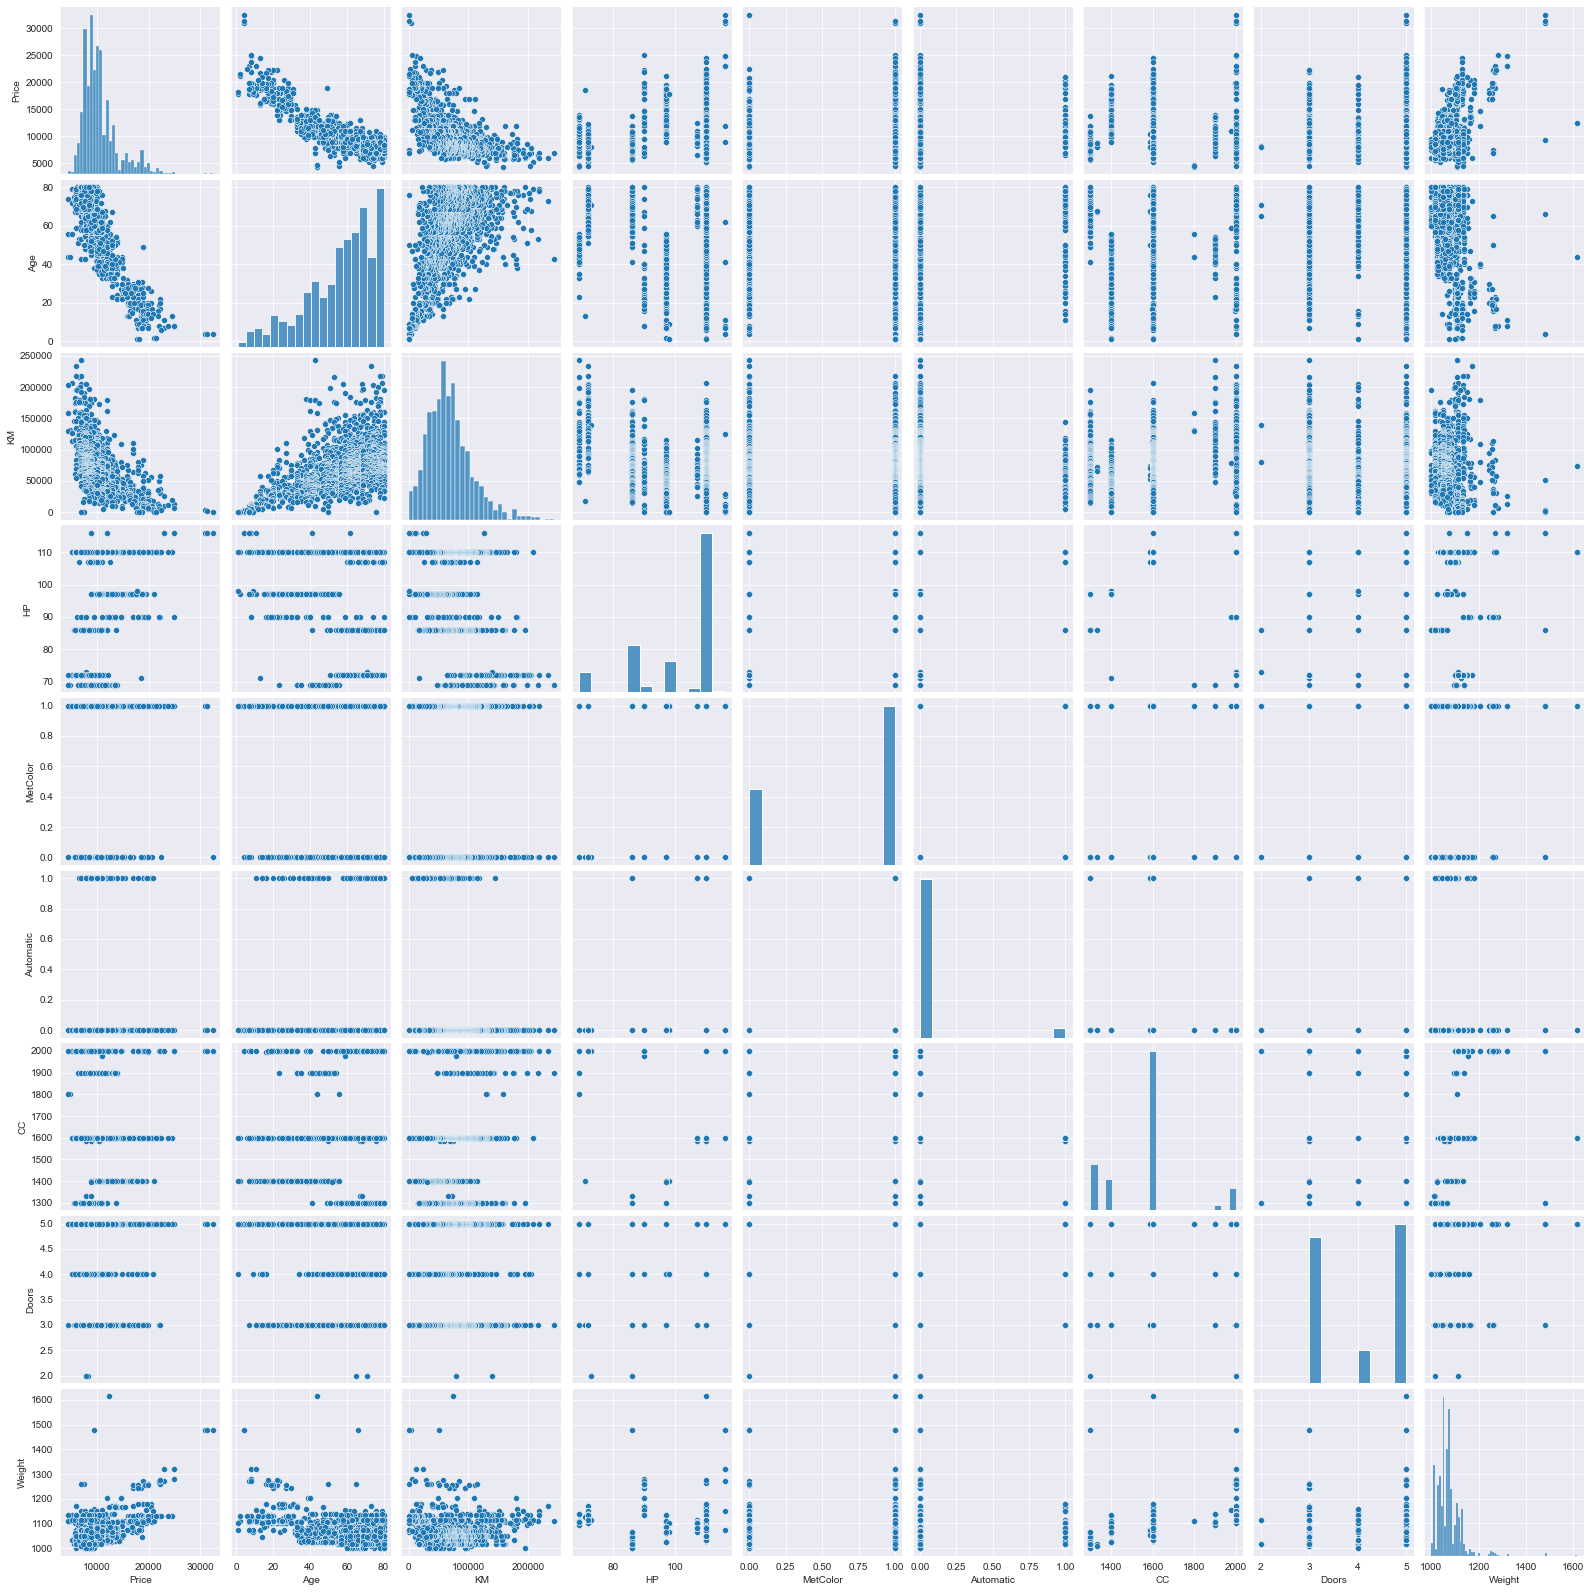

In [20]:
sns.pairplot(dataset_num)

# Feature Engineering

- Transform categorical variables to numbers
- Scaling/transformations to get everything in the same range


In [21]:
#Check again scales of the parameters
dataset_num.describe()

,Price,Age,KM,HP,MetColor,Automatic,CC,Doors,Weight
count,1425.000000,1425.000000,1425.000000,1425.000000,1425.000000,1425.000000,1425.000000,1425.000000,1425.000000
mean,10646.220351,56.170526,68800.280000,100.803509,0.675789,0.056140,1565.028070,4.037193,1071.576842
std,3508.671984,18.493082,37508.195872,12.744160,0.468243,0.230273,186.774433,0.952167,51.870760
min,4350.000000,1.000000,1.000000,69.000000,0.000000,0.000000,1300.000000,2.000000,1000.000000
25%,8450.000000,44.000000,43120.000000,86.000000,0.000000,0.000000,1400.000000,3.000000,1040.000000
50%,9900.000000,61.000000,63635.000000,110.000000,1.000000,0.000000,1600.000000,4.000000,1065.000000
75%,11900.000000,70.000000,87358.000000,110.000000,1.000000,0.000000,1600.000000,5.000000,1085.000000
max,32500.000000,80.000000,243000.000000,116.000000,1.000000,1.000000,2000.000000,5.000000,1615.000000


In [22]:
# There are a lot of different ranges. I decide to scale the continous features
# (age,km,cc,hp and weight).
# I won't scale price because it is the target feature.
# Chose the minmax scaler because for example age does not really have a normal distribution.

scale_columns =  ['Age','KM','HP','CC','Weight']
features_to_scale = dataset_num.loc[:,scale_columns]
features_to_scale = MinMaxScaler().fit_transform(features_to_scale.values)

dataset_scaled = dataset_num.copy() #Copy it to not overwrite it
dataset_scaled[scale_columns]=features_to_scale

In [23]:
#Check data again

dataset_scaled.info()

#Now everything is in a similar range

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1425 entries, 0 to 1435
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Price      1425 non-null   int64  
 1   Age        1425 non-null   float64
 2   KM         1425 non-null   float64
 3   HP         1425 non-null   float64
 4   MetColor   1425 non-null   int64  
 5   Automatic  1425 non-null   int64  
 6   CC         1425 non-null   float64
 7   Doors      1425 non-null   int64  
 8   Weight     1425 non-null   float64
dtypes: float64(5), int64(4)
memory usage: 111.3 KB


/Users/mimmo/opt/anaconda3/envs/DataAnalytics/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/mimmo/opt/anaconda3/envs/DataAnalytics/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/mimmo/opt/anaconda3/envs/DataAnalytics/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use e

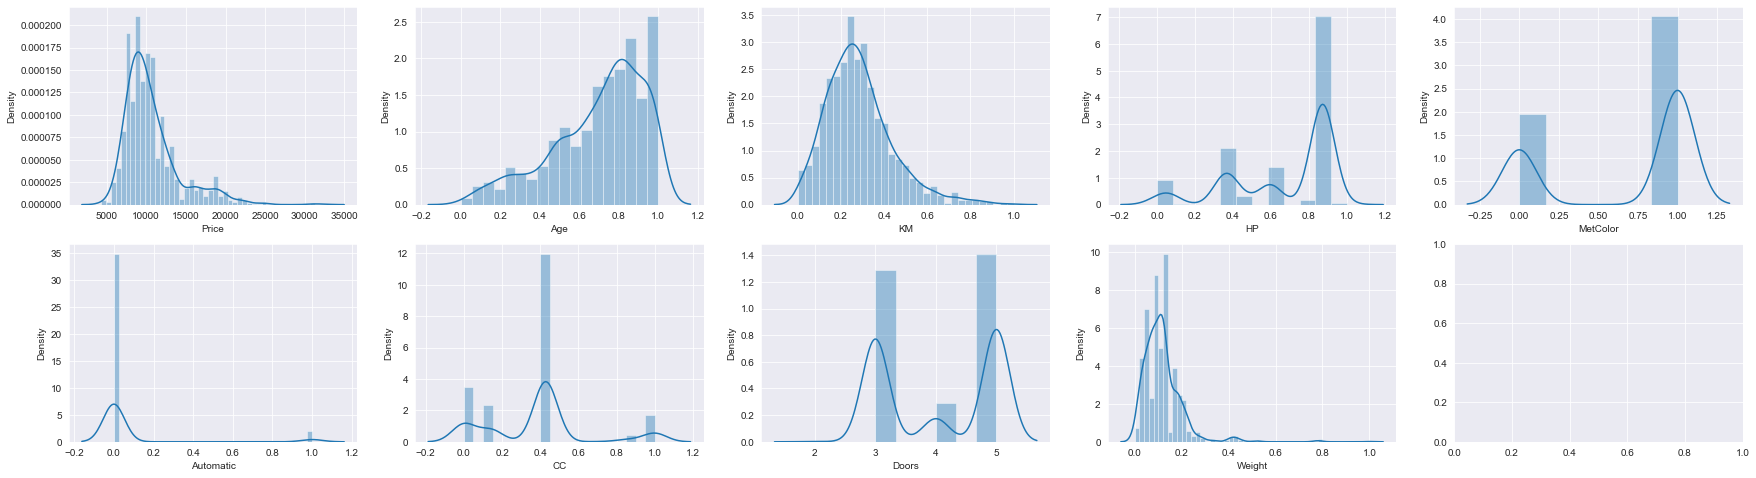

In [24]:
#Check if some data needs to be transformed, plot again the distributions

nrow=2
ncol = 5
fig,ax = plt.subplots(nrow,ncol,figsize=(30, 8))

r=0
c=0
for col in dataset_scaled:
    sns.distplot(dataset_scaled[col],ax=ax[r][c])
    c=c+1
    if c==ncol:
        r=r+1
        c=0

#Price, km and weight are positvely skewed could try a log transform
#Age is kind of negatively skewed but actually not really normally distributed at all...could try a root transform


/Users/mimmo/opt/anaconda3/envs/DataAnalytics/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/mimmo/opt/anaconda3/envs/DataAnalytics/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


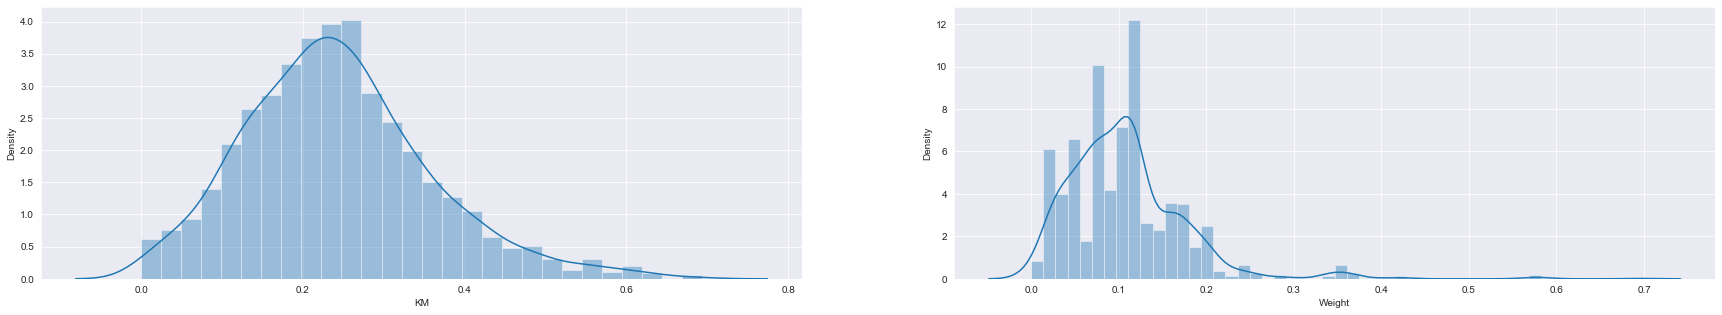

In [25]:
log_transform_cols = ["KM","Weight"]
df_log_transform = dataset_scaled[log_transform_cols].copy()

nrow=1
ncol = 2
fig,ax = plt.subplots(ncols=ncol,figsize=(30, 5))

c=0
r=0
for col in df_log_transform:
    df_log_transform[col] = df_log_transform[col].apply(lambda x : np.log(x+1)) 
    sns.distplot(df_log_transform[col],ax=ax[c])
    c=c+1

#Helped quite well for the KM feature.
#For Weight, not so much improvement but also not worse either, so we will just keep it

/Users/mimmo/opt/anaconda3/envs/DataAnalytics/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/mimmo/opt/anaconda3/envs/DataAnalytics/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


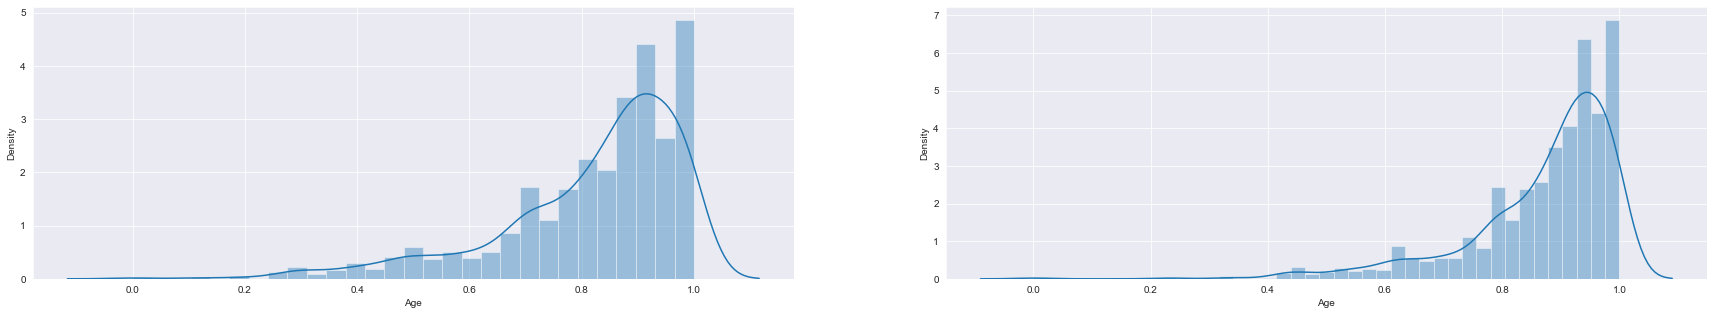

In [26]:
root_transform_cols =["Age"]
df_root_transform = dataset_scaled[root_transform_cols].copy()
df_cube_transform = df_root_transform.copy()

for col in df_root_transform:
    df_root_transform[col] = df_root_transform[col].apply(lambda x : np.sqrt(x)) 
    df_cube_transform[col] = df_cube_transform[col].apply(lambda x : x**(1/3)) 

#Check difference between root and cube transform for age
fig,ax = plt.subplots(ncols=ncol,figsize=(30, 5))
sns.distplot(df_root_transform['Age'],ax=ax[0])
sns.distplot(df_cube_transform['Age'],ax=ax[1])
plt.show()
#That didn't really help because age is not normally distributed in the first place, so do not keep this

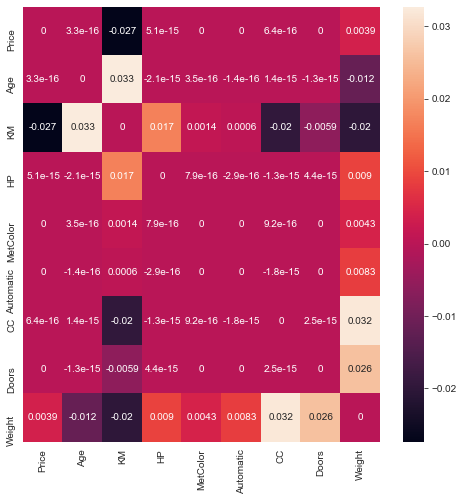

In [27]:
#So at the end
dataset_scaled[log_transform_cols] = df_log_transform

#Just wanted to see how it changed the correlations
data_corr_diff = dataset_scaled.corr()-data_corr

f, ax = plt.subplots(1,1,figsize=(8, 8))
sns.heatmap(data_corr_diff,annot=True)
plt.show()

#No large differences found in the correlations after transforming the values.

In [28]:
#Change categorical variables to numerical one
#Only fuel type is an object so needs to be transformed
#Since there are only three different fuel types can use label encoder because it won't add a lot to the scale

dataset_categorical = dataset["FuelType"].copy()

# Carry out label encoding
lb_make = LabelEncoder() 
dataset_categorical  = lb_make.fit_transform(dataset_categorical)

#Check range
print(len(dataset_categorical))
print(dataset_categorical.min())
print(dataset_categorical.max())

1425
0
2


In [29]:
#Put all features together into one dataframe
X = dataset_scaled.copy()
X["FuelType"]=dataset_categorical
X.drop("Price",axis=1,inplace=True)

y = dataset_scaled["Price"]
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1425 entries, 0 to 1435
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        1425 non-null   float64
 1   KM         1425 non-null   float64
 2   HP         1425 non-null   float64
 3   MetColor   1425 non-null   int64  
 4   Automatic  1425 non-null   int64  
 5   CC         1425 non-null   float64
 6   Doors      1425 non-null   int64  
 7   Weight     1425 non-null   float64
 8   FuelType   1425 non-null   int64  
dtypes: float64(5), int64(4)
memory usage: 111.3 KB


In [30]:
dataset_new = pd.concat([dataset_scaled, X["FuelType"]], axis=1)
dataset_new.head()

,Price,Age,KM,HP,MetColor,Automatic,CC,Doors,Weight,FuelType
0,13500,0.278481,0.176768,0.446809,1,0,1.0,3,0.237672,1
1,13750,0.278481,0.262479,0.446809,1,0,1.0,3,0.237672,1
2,13950,0.291139,0.158410,0.446809,1,0,1.0,3,0.237672,1
3,14950,0.316456,0.180259,0.446809,0,0,1.0,3,0.237672,1
4,13750,0.367089,0.147068,0.446809,0,0,1.0,3,0.244061,1


# Simple Linear Regression

In [31]:
#Select the x variable that has a higher linear relation with price (our target variable)

X = dataset_new.Weight 
y = dataset_new.Price

In [32]:
#Split data into train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [33]:
print('Shape of the raw data (x): {}'.format (X.shape))
print('Shape of the target variable (y): {}'.format (y.shape))

print('\nShape of the Train data (x_train): {}'.format (X_train.shape))
print('Shape of the Train data (y_train): {}'.format (y_train.shape))

print('\nShape of the Test data (x_test): {}'.format (X_test.shape))
print('Shape of the target Test data (y_test): {}'.format (y_test.shape))

Shape of the raw data (x): (1425,)
Shape of the target variable (y): (1425,)

Shape of the Train data (x_train): (997,)
Shape of the Train data (y_train): (997,)

Shape of the Test data (x_test): (428,)
Shape of the target Test data (y_test): (428,)


In [34]:
#Convert values into numpy arrays

y_train =  np.array(y_train).reshape(-1, 1)  
X_train = np.array(X_train).reshape(-1, 1) 

y_test =  np.array(y_test).reshape(-1, 1)  
X_test = np.array(X_test).reshape(-1, 1)

In [35]:
#Instantiate and train the model

lr = LinearRegression(normalize=True)

lr.fit(X_train, y_train)

LinearRegression(normalize=True)

In [36]:
#Target predicted values and covert them into np array

y_pred = lr.predict(X_test)
y_pred = np.array(y_pred).reshape(-1, 1)

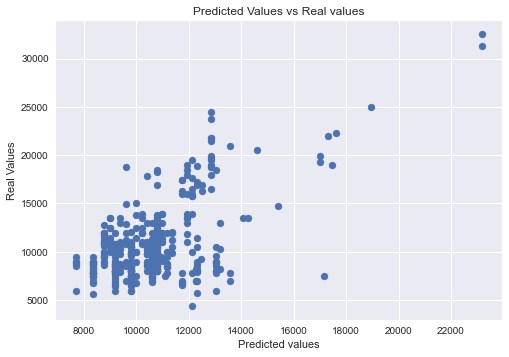

In [37]:
#Plotting predicted vs real values

plt.style.use('seaborn')
plt.scatter(y_pred, y_test)
plt.title('Predicted Values vs Real values')
plt.xlabel('Predicted values')
plt.ylabel('Real Values')
plt.show()

#Not so good...seems the prediction is not really accurate

## Model Evaluation

In [38]:
#Evaluate model performance

#TEST METRICS

MAE_l = metrics.mean_absolute_error(y_test, y_pred)
MSE_l = metrics.mean_squared_error(y_test, y_pred)
RMSE_l = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
R2_l = r2_score(y_test, y_pred)

print('MAE:', MAE_l)
print('MSE:', MSE_l)
print('RMSE:', round(RMSE_l,3))
print('R2 Score:', R2_l)

MAE: 2271.240130882988
MSE: 9257913.442193426
RMSE: 3042.682
R2 Score: 0.34613015702800287


- R2 score low as also shown by plot.

In [39]:
#TRAIN METRICS

y_predTrain = lr.predict(X_train)
y_predTrain = np.array(y_predTrain).reshape(-1, 1)

In [40]:
MAE_lTrain = metrics.mean_absolute_error(y_train, y_predTrain)
MSE_lTrain = metrics.mean_squared_error(y_train,y_predTrain)
RMSE_lTrain = np.sqrt(metrics.mean_squared_error(y_train, y_predTrain))
R2_lTrain = r2_score(y_train, y_predTrain)

print('MAE:', MAE_lTrain)
print('MSE:', MSE_lTrain)
print('RMSE:', round(RMSE_lTrain,3))
print('R2 Score:', R2_lTrain)

MAE: 2111.5119611207556
MSE: 8029523.5633255495
RMSE: 2833.641
R2 Score: 0.301462449678663


# Multilinear Regression

In [41]:
#Split data into target and feature variables

features = dataset_new[["Age", "KM", "HP", "MetColor", "Automatic", "CC",
                           "Doors", "Weight", "FuelType"]]
target = dataset_scaled.Price

In [42]:
X = features
y = target

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 7)

In [44]:
mlr = LinearRegression()
mlr.fit(X_train, y_train)

LinearRegression()

In [45]:
y_pred = mlr.predict(X_test)

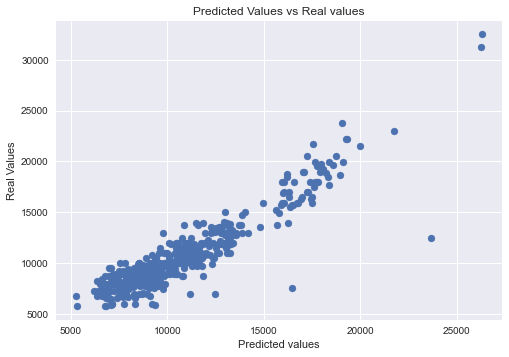

In [46]:
#Plotting predicted vs real values

plt.style.use('seaborn')
plt.scatter(y_pred, y_test)
plt.title('Predicted Values vs Real values')
plt.xlabel('Predicted values')
plt.ylabel('Real Values')
plt.show()

#Now seems better...apart from some bad predicted points the plot is much more linear

## Model Evaluation

In [47]:
#Evaluate performance

#TEST METRICS

MAE_ml = metrics.mean_absolute_error(y_test, y_pred)
MSE_ml = metrics.mean_squared_error(y_test, y_pred)
RMSE_ml = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
R2_ml = r2_score(y_test, y_pred)

print('MAE:', MAE_ml)
print('MSE:', MSE_ml)
print('RMSE:', round(RMSE_ml,3))
print('R2 Score:', R2_ml)

MAE: 971.9703338822268
MSE: 1964104.1458166172
RMSE: 1401.465
R2 Score: 0.8509338133557021


- R2 score improved a lot.

In [48]:
# TRAIN METRICS

y_predTrain = mlr.predict(X_train)

MAE_mlTrain = metrics.mean_absolute_error(y_train, y_predTrain)
MSE_mlTrain = metrics.mean_squared_error(y_train,y_predTrain)
RMSE_mlTrain = np.sqrt(metrics.mean_squared_error(y_train, y_predTrain))
R2_mlTrain = r2_score(y_train, y_predTrain)

print('MAE:', MAE_mlTrain)
print('MSE:', MSE_mlTrain)
print('RMSE:', round(RMSE_mlTrain,3))
print('R2 Score:', R2_mlTrain)

MAE: 922.9338881156553
MSE: 1614471.6320343174
RMSE: 1270.619
R2 Score: 0.8639907155024832


# Polynomial Regression

In [49]:
poly_reg = PolynomialFeatures(degree = 2)
X_poly = poly_reg.fit_transform(X)
X_poly

array([[1.00000000e+00, 2.78481013e-01, 1.76768421e-01, ...,
        5.64878141e-02, 2.37671652e-01, 1.00000000e+00],
       [1.00000000e+00, 2.78481013e-01, 2.62479168e-01, ...,
        5.64878141e-02, 2.37671652e-01, 1.00000000e+00],
       [1.00000000e+00, 2.91139241e-01, 1.58410278e-01, ...,
        5.64878141e-02, 2.37671652e-01, 1.00000000e+00],
       ...,
       [1.00000000e+00, 8.86075949e-01, 6.76781476e-02, ...,
        5.80691992e-04, 4.81951032e-02, 4.00000000e+00],
       [1.00000000e+00, 8.73417722e-01, 6.72934790e-02, ...,
        5.80691992e-04, 4.81951032e-02, 4.00000000e+00],
       [1.00000000e+00, 9.49367089e-01, 0.00000000e+00, ...,
        2.89175005e-02, 3.40102928e-01, 4.00000000e+00]])

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size = 0.2, random_state = 12)

In [51]:
poly_reg.fit(X_poly, y_train)
regressor_poly2 = LinearRegression()
regressor_poly2.fit(X_train, y_train)

LinearRegression()

In [52]:
y_pred = regressor_poly2.predict(X_test)
y_pred

array([ 9613.85180071,  7289.18384758,  8254.21975122, 17229.51846794,
       11828.53766234,  8168.90807661,  8556.60078831, 17510.67802056,
       10299.96234022, 19398.73061241, 11759.42279657,  9257.36593473,
       10195.14494774, 10007.13206771,  8404.43531463,  9380.51698613,
        7496.22026075,  9573.82177678,  8446.58469717, 10156.94661167,
       18688.85145256,  7262.08708858, 10751.15346867,  9968.79326015,
       15283.0781051 , 11345.20137021,  9827.40437641, 10012.16395196,
       11761.79005085, 15233.33804282, 21266.34301933,  9245.66029304,
       16261.03250137,  8949.17670148,  8408.81160199, 12196.82878425,
        9374.40179148, 15217.20869404, 11218.13460142,  7685.53350064,
       10053.6643227 ,  8272.64218131,  9478.29262294,  8608.30533014,
       31003.80886948, 13329.00933183, 13784.57332002,  7801.50037512,
        9001.66919643, 10346.05270651,  9318.81815742,  8766.27981778,
       11596.00563835,  9614.68160631,  8822.92156201, 19388.74449793,
      

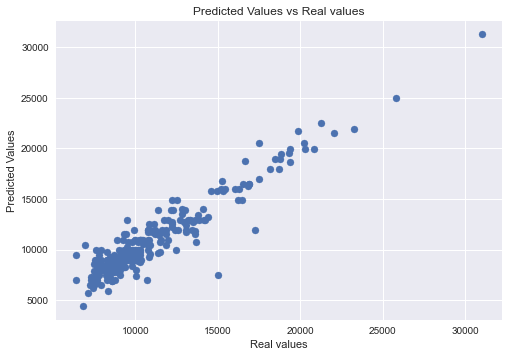

In [53]:
plt.style.use('seaborn')
plt.scatter(y_pred, y_test,
          label = 'Test data')

plt.title('Predicted Values vs Real values')
plt.xlabel('Real values')
plt.ylabel('Predicted Values')
plt.show()

## Model Evaluation

In [65]:
#Evaluate performance

#TEST METRICS

MAE_pl = metrics.mean_absolute_error(y_test, y_pred)
MSE_pl = metrics.mean_squared_error(y_test, y_pred)
RMSE_pl = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
R2_pl = r2_score(y_test, y_pred)

print('MAE:', round(MAE_pl,3))
print('MSE:', round(MSE_pl,3))
print('RMSE:', round(RMSE_pl,3))
print('R2 Score:', R2_pl)

MAE: 811.021
MSE: 1123630.582
RMSE: 1060.014
R2 Score: 0.9031894779790623


In [55]:
#TRAIN METRICS

y_predTrain = regressor_poly2.predict(X_train)

MAE_plTrain = metrics.mean_absolute_error(y_train, y_predTrain)
MSE_plTrain = metrics.mean_squared_error(y_train,y_predTrain)
RMSE_plTrain = np.sqrt(metrics.mean_squared_error(y_train, y_predTrain))
R2_plTrain = r2_score(y_train, y_predTrain)

print('MAE:', round(MAE_plTrain,3))
print('MSE:', round(MSE_plTrain,3))
print('RMSE:', round(RMSE_plTrain,3))
print('R2 Score:', R2_plTrain)

MAE: 804.012
MSE: 1091890.159
RMSE: 1044.935
R2 Score: 0.9098679248248699


- R2 score improved even more - the best result so far.

In [56]:
#Carry out cross validation

cv_scores = cross_val_score(LinearRegression(), X_train, y_train,cv=10, scoring='r2') # Let's define the K and the scoring method

print('Cross Validation R2_score: {}'.format(cv_scores.round(2)))

cv_scores = np.mean(cv_scores).round(3)
print("\nAverage 10-Fold CV R2_score: {}".format(cv_scores))

Cross Validation R2_score: [0.93 0.8  0.45 0.86 0.87 0.89 0.87 0.88 0.88 0.93]

Average 10-Fold CV R2_score: 0.836


-  Can see that there is a quite large range of values and that the split which was chosen gave the highest score. 

# Randomized Grid Search 

- Carry out randomized grid search with best model which was the polynomial regression model.
- Also use poly model which should be original model but then with cross validation

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size = 0.2, random_state = 10)

model_params_linreg = {
    'poly': {
         'model': LinearRegression(),
         'params': {}
    } ,
    'ridge': {
        'model': Ridge(),
        'params': {
            'alpha': [0.1,0.5, 1.0, 10.0, 0.001,0.01,0.5,0.1]
            }
    },
    
    'lasso': {
        'model': Lasso(),
        'params': {
            'alpha' : [0.1,0.5, 1.0, 10.0, 0.001,0.01,0.5,0.1]
            }
    },
    
    'svr': {
        'model': SVR(),
        'params': {
            'C': [0.01, 0.1, 0.5, 1, 10],
            'kernel': ['linear', 'rbf', 'poly'],
            'gamma': [1, 0.75, 0.5, 0.25, 0.1],
            'degree':[2,3]
        }
    }
}

metrics_dev = ['r2']

In [58]:
# n_iter: int, default=10; Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.

import time
start = time.time()

scores_randomized = []

for model_name, mp in model_params_linreg.items():
    print("{} model training in progress...".format(model_name))
    regr =  RandomizedSearchCV(mp['model'], mp['params'], cv=10, scoring=metrics_dev, refit='r2', n_iter=8)
    regr.fit(X_train, y_train)
    scores_randomized.append({
        'model': model_name,
        'best_score': regr.best_score_,
        'best_params': regr.best_params_,
        'Avg MAE': regr.cv_results_['mean_test_r2'],
        'Avg RMSE' : regr.cv_results_['mean_test_r2'],
        'Avg R1': regr.cv_results_['mean_test_r2']
    })
    print("{} model training finished".format(model_name),"\n")

end = time.time()

poly model training in progress...
poly model training finished 

ridge model training in progress...


/Users/mimmo/opt/anaconda3/envs/DataAnalytics/lib/python3.7/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 1 is smaller than n_iter=8. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


ridge model training finished 

lasso model training in progress...


/Users/mimmo/opt/anaconda3/envs/DataAnalytics/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 520847874.4403853, tolerance: 1279728.3591938596
  positive)
/Users/mimmo/opt/anaconda3/envs/DataAnalytics/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 495201004.4025613, tolerance: 1294147.9528218326
  positive)
/Users/mimmo/opt/anaconda3/envs/DataAnalytics/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 527477614.1391293, tolerance: 1234028.5257443471
  positive)
/Users/mimmo/opt/anaconda3/envs/DataAnalytics/lib/python3.7/site-packages/sklearn/linear_model/_coordinate

/Users/mimmo/opt/anaconda3/envs/DataAnalytics/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 594146014.050963, tolerance: 1279728.3591938596
  positive)
/Users/mimmo/opt/anaconda3/envs/DataAnalytics/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 551242640.804358, tolerance: 1294147.9528218326
  positive)
/Users/mimmo/opt/anaconda3/envs/DataAnalytics/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 600256967.4300678, tolerance: 1234028.5257443471
  positive)
/Users/mimmo/opt/anaconda3/envs/DataAnalytics/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_d

/Users/mimmo/opt/anaconda3/envs/DataAnalytics/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114368140.68548787, tolerance: 1293263.4761017545
  positive)
/Users/mimmo/opt/anaconda3/envs/DataAnalytics/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 520847874.4403853, tolerance: 1279728.3591938596
  positive)
/Users/mimmo/opt/anaconda3/envs/DataAnalytics/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 495201004.4025613, tolerance: 1294147.9528218326
  positive)
/Users/mimmo/opt/anaconda3/envs/DataAnalytics/lib/python3.7/site-packages/sklearn/linear_model/_coordinat

lasso model training finished 

svr model training in progress...
svr model training finished 



## Model Evaluation

In [59]:
results_randomized = pd.DataFrame(scores_randomized,columns=['model','best_score','best_params','Avg MAE','Avg RMSE','Avg R1'])
results_randomized


,model,best_score,best_params,Avg MAE,Avg RMSE,Avg R1
0,poly,0.789860,{},[0.7898602204266316],[0.7898602204266316],[0.7898602204266316]
1,ridge,0.871875,{'alpha': 0.1},"[0.8718751876685962, 0.868409577491111, 0.8665...","[0.8718751876685962, 0.868409577491111, 0.8665...","[0.8718751876685962, 0.868409577491111, 0.8665..."
2,lasso,0.872857,{'alpha': 1.0},"[0.8626421959188203, 0.8714069916390621, 0.872...","[0.8626421959188203, 0.8714069916390621, 0.872...","[0.8626421959188203, 0.8714069916390621, 0.872..."
3,svr,0.828124,"{'kernel': 'poly', 'gamma': 1, 'degree': 3, 'C...","[-0.0473560577558656, 0.003490373110472422, 0....","[-0.0473560577558656, 0.003490373110472422, 0....","[-0.0473560577558656, 0.003490373110472422, 0...."


- There is an improvement of the ridge and lasso regularization results compared to the original poly model.
- Since the polynomial features are used it would be expected that the non-linear poly kernel is more efficient then the linear kernel. That is not the case and the SVR performs poorly. 

In [60]:
#Train model with best result
best_model = Lasso(alpha=1,tol=0.01)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

In [61]:
#TEST METRICS

MAE_bm = metrics.mean_absolute_error(y_test, y_pred)
MSE_bm = metrics.mean_squared_error(y_test, y_pred)
RMSE_bm = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
R2_bm = r2_score(y_test, y_pred)

print('MAE:', round(MAE_bm,3))
print('MSE:', round(MSE_bm,3))
print('RMSE:', round(RMSE_bm,3))
print('R2 Score:', R2_bm)

MAE: 811.021
MSE: 1123630.582
RMSE: 1060.014
R2 Score: 0.9031894779790623


In [62]:
#TRAIN METRICS

y_predTrain = best_model.predict(X_train)

MAE_bmTrain = metrics.mean_absolute_error(y_train, y_predTrain)
MSE_bmTrain = metrics.mean_squared_error(y_train,y_predTrain)
RMSE_bmTrain = np.sqrt(metrics.mean_squared_error(y_train, y_predTrain))
R2_bmTrain = r2_score(y_train, y_predTrain)

print('MAE:', round(MAE_bmTrain,3))
print('MSE:', round(MSE_bmTrain,3))
print('RMSE:', round(RMSE_bmTrain,3))
print('R2 Score:', R2_bmTrain)

MAE: 836.448
MSE: 1247135.226
RMSE: 1116.752
R2 Score: 0.8998057829187613


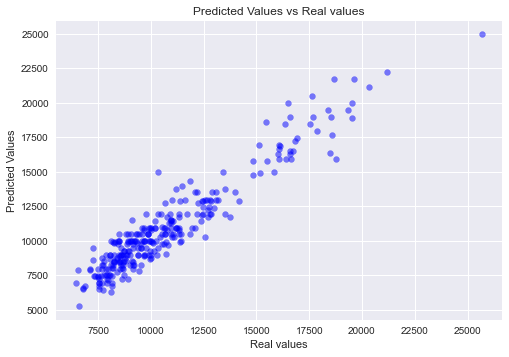

In [63]:
plt.style.use('seaborn')
plt.scatter(y_pred, y_test, color = 'blue', marker = 'o', s = 35, alpha = 0.5)

plt.title('Predicted Values vs Real values')
plt.xlabel('Real values')
plt.ylabel('Predicted Values')
plt.show()

# Conclusions

In [64]:
print("*SLR Test Metrics*")
print('MAE:', MAE_l)
print('MSE:', MSE_l)
print('RMSE:', round(RMSE_l,3))
print('R2 Score:', R2_l)
print("----------------------")
print("*SLR Train Metrics*")
print('MAE:', MAE_lTrain)
print('MSE:', MSE_lTrain)
print('RMSE:', round(RMSE_lTrain,3))
print('R2 Score:', R2_lTrain)
print("----------------------")
print("*MLR Test Metrics*")
print('MAE:', MAE_ml)
print('MSE:', MSE_ml)
print('RMSE:', round(RMSE_ml,3))
print('R2 Score:', R2_ml)
print("----------------------")
print("*MLR Train Metrics*")
print('MAE:', MAE_mlTrain)
print('MSE:', MSE_mlTrain)
print('RMSE:', round(RMSE_mlTrain,3))
print('R2 Score:', R2_mlTrain)
print("----------------------")
print("*Poly Test Metrics*")
print('MAE:', round(MAE_pl,3))
print('MSE:', round(MSE_pl,3))
print('RMSE:', round(RMSE_pl,3))
print('R2 Score:', R2_pl)
print("----------------------")
print("*Poly Train Metrics*")
print('MAE:', round(MAE_plTrain,3))
print('MSE:', round(MSE_plTrain,3))
print('RMSE:', round(RMSE_plTrain,3))
print('R2 Score:', R2_plTrain)
print("----------------------")
print("*Best model randomnized grid search test metrics*")
print('MAE:', round(MAE_bm,3))
print('MSE:', round(MSE_bm,3))
print('RMSE:', round(RMSE_bm,3))
print('R2 Score:', R2_bm)
print("----------------------")
print("*Best model randomnized grid search train metrics*")
print('MAE:', round(MAE_bmTrain,3))
print('MSE:', round(MSE_bmTrain,3))
print('RMSE:', round(RMSE_bmTrain,3))
print('R2 Score:', R2_bmTrain)

*SLR Test Metrics*
MAE: 2271.240130882988
MSE: 9257913.442193426
RMSE: 3042.682
R2 Score: 0.34613015702800287
----------------------
*SLR Train Metrics*
MAE: 2111.5119611207556
MSE: 8029523.5633255495
RMSE: 2833.641
R2 Score: 0.301462449678663
----------------------
*MLR Test Metrics*
MAE: 971.9703338822268
MSE: 1964104.1458166172
RMSE: 1401.465
R2 Score: 0.8509338133557021
----------------------
*MLR Train Metrics*
MAE: 922.9338881156553
MSE: 1614471.6320343174
RMSE: 1270.619
R2 Score: 0.8639907155024832
----------------------
*Poly Test Metrics*
MAE: 843.479
MSE: 1419609.989
RMSE: 1191.474
R2 Score: 0.8911108066913271
----------------------
*Poly Train Metrics*
MAE: 804.012
MSE: 1091890.159
RMSE: 1044.935
R2 Score: 0.9098679248248699
----------------------
*Best model randomnized grid search test metrics*
MAE: 811.021
MSE: 1123630.582
RMSE: 1060.014
R2 Score: 0.9031894779790623
----------------------
*Best model randomnized grid search train metrics*
MAE: 836.448
MSE: 1247135.226
RMS

- The polynomial model with regularization led to the highest R2 score. The training and test metrics are similar so there does not seem to be any overfitting.